In [1]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
# model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')
# model_rft = joblib.load('savemodel_rf.sav')


model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [2]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [3]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [5]:
x_pre = imputer.transform(dfpre)

In [6]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [7]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [8]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [9]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [10]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [11]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [12]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [13]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [14]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            3506 non-null   int64         
 1   Time                                  3506 non-null   datetime64[ns]
 2   LON                                   3506 non-null   float64       
 3   LAT                                   3506 non-null   float64       
 4   Temperature above oceans              3506 non-null   float64       
 5   Air density above oceans              3405 non-null   float64       
 6   Max wave height                       3152 non-null   float64       
 7   Swell period                          3152 non-null   float64       
 8   Wind wave period                      3152 non-null   float64       
 9   Wave period                           3152 non-null   float64       
 10  

Add test data for 3 months into validation data

In [16]:
# Data Splitting

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 
x_train,x_test,y_train,y_test = train_test_split(df.drop(['SOG']
                                                                 ,axis=1)
                                                                ,df.SOG,test_size=0.2,random_state=42)

In [17]:
df_test = pd.concat([x_test,y_test],axis=1)

In [18]:
# Extract three months of data from the test datasets

# Test with more data
dfdate1 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-01']
dfdate2 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-02']
dfdate3 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-03']
dfdate4 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-04']
dfdate5 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-05']
# ##########################################################################

dfdate7 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-07']
dfdate8 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-08']
dfdate9 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-09']
dfdate10 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-10']
dfdate11 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-11']
dfdate12 = df_test[df_test['Time'].dt.strftime('%Y-%m') == '2021-12']



# Concatenate 6 months data into df_ship

# df_months6 = pd.concat([dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])

# Test section with more data 

df_months6 = pd.concat([dfdate1,dfdate2,dfdate3,dfdate4,dfdate5,dfdate7,dfdate8,dfdate9,dfdate10,dfdate11,dfdate12])



In [19]:
df_ship = df_months6.drop(['Unnamed: 0','LON','LAT','Time','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction,SOG
702,273.350830,1.639553,5.229636,3.234901,4.094504,277.717895,0.854533,0.560547,0.642914,4.834130,...,167.639484,106.755485,100.890698,23.424774,57.035614,0.105747,7.899833,296.750531,177.634530,17.796529
425,277.373535,1.363195,4.333393,2.725380,3.808491,278.187500,0.717416,0.493626,0.452545,5.385540,...,6.853836,57.056116,81.702482,162.263868,121.675917,0.068111,6.477506,271.208773,155.118725,18.973217
7305,275.485107,1.207072,5.079647,2.175282,5.028988,281.692139,0.642756,0.637711,0.065796,5.470698,...,63.460148,151.271969,50.719773,118.366245,50.614403,0.208269,2.273218,235.776237,201.044120,18.584076
302,274.433594,2.649884,4.345334,4.285193,4.287695,277.633911,1.368544,0.258740,1.343628,5.289444,...,81.400359,144.552992,45.264404,96.999874,96.106695,0.256832,10.366420,20.462256,186.385110,17.367918
615,275.730713,1.330918,3.942446,3.345863,3.439272,277.380493,0.703928,0.279053,0.645996,5.379842,...,5.408478,34.711324,122.409087,171.729094,165.529997,0.028694,6.797408,286.243468,66.123666,18.056660


In [20]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [21]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [22]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

In [23]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [24]:
X = imputer.transform(df_ship2)

In [25]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [26]:
x_months6 = df_ship2tr.drop(['sog'],axis=1)
y_months6 = df_ship2tr.sog

In [27]:
print("Amount of the test dataset is:",len(x_months6))

Amount of the test dataset is: 702


Special Section

In [28]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [29]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [30]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [31]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [32]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [33]:
stats2 = dfdate6['curspeed'].value_counts()

In [34]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [35]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [36]:
xdate = imputer.transform(dfdate6)

In [37]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [38]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [39]:
print(f"Amount of the test dataset is {len(x_date)}")

Amount of the test dataset is 322


In [40]:
dfdate6.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,sog,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,truenorthwinddir,truenorthcurrentdir
count,322.000000,287.000000,305.000000,287.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,287.000000,322.000000,322.000000
mean,287.133146,3.411435,287.261956,0.665559,5.282713,17.449699,197.436423,189.432992,5.832751,0.092478,86.173628,86.811052,95.744646,193.881748,155.282564
std,6.306975,1.018301,4.927599,0.572845,0.162420,3.069944,86.327689,88.499255,3.020207,0.068917,62.588681,59.359251,63.892090,89.816472,102.716811
min,269.606903,1.915993,275.485352,0.073242,4.754639,5.224523,82.664990,79.551648,0.441768,0.002006,0.565115,1.295289,0.200645,3.207821,0.112383
25%,285.292786,2.656420,286.814697,0.254164,5.199718,16.568861,103.569971,101.685445,3.442231,0.043318,24.875738,28.600108,29.381058,120.064906,83.669063
50%,289.505615,3.125275,289.625977,0.431268,5.290842,18.413643,193.360899,125.125521,5.528616,0.073482,82.212973,79.271353,104.919772,193.709354,129.304190
75%,291.391602,3.919880,290.497070,0.836488,5.381292,19.421633,283.259801,279.238872,7.569939,0.123647,149.107733,146.039105,159.782560,279.768652,249.619550
max,294.685303,6.291378,292.665649,2.565230,5.657671,21.031230,319.851509,304.969531,13.386999,0.417155,179.309007,179.405213,179.699225,357.291804,359.450078


Reverse Modelling Test 

Concatenate test and validation data 

In [41]:
x_date_c = pd.concat([x_date,x_months6])
y_date_c = pd.concat([y_date,y_months6])

In [42]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_RMSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    RMSE = -score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = -score_RMSE.max()
    min_RMSE = -score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_MAD,score_RMSE    

RFR evaluation

In [43]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_date,y_date)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.7562, std = 0.2182, max = 0.9392, min = 0.3669
explained Variance = 0.7865, std = 0.1911, max = 0.9397, min = 0.4465
MAE = 0.9594, std = 0.4931, max = 0.5719, min = 2.3230
RMSE = 1.3125, std = 0.7283, max = 0.6874, min = 3.2810
MAD = 0.7261, std = 0.2845, max = 0.2943, min = 1.4170



In [44]:
r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.7519, std = 0.2245, max = 0.9362, min = 0.3532
explained Variance = 0.7862, std = 0.1896, max = 0.9374, min = 0.4354
MAE = 0.9581, std = 0.4977, max = 0.5610, min = 2.3235
RMSE = 1.3207, std = 0.7349, max = 0.6768, min = 3.3163
MAD = 0.7263, std = 0.2968, max = 0.1940, min = 1.3525



In [45]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_date,y_date)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.7970, std = 0.1582, max = 0.9446, min = 0.4831
explained Variance = 0.8234, std = 0.1285, max = 0.9478, min = 0.6018
MAE = 0.9057, std = 0.3844, max = 0.5302, min = 1.9772
RMSE = 1.2205, std = 0.5432, max = 0.6185, min = 2.6923
MAD = 0.6861, std = 0.2689, max = 0.3620, min = 1.3711



In [46]:
r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8095, std = 0.1467, max = 0.9451, min = 0.5675
explained Variance = 0.8324, std = 0.1246, max = 0.9468, min = 0.6294
MAE = 0.8844, std = 0.3895, max = 0.5277, min = 1.9626
RMSE = 1.1892, std = 0.5493, max = 0.6156, min = 2.6718
MAD = 0.6730, std = 0.2809, max = 0.2382, min = 1.3678



In [47]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr_ftr,x_date,y_date)

Model Performance of DecisionTreeRegressor()
R^2 = 0.6575, std = 0.2908, max = 0.9305, min = -0.0145
explained Variance = 0.6817, std = 0.3234, max = 0.9598, min = -0.2223
MAE = 1.0633, std = 0.4107, max = 0.5557, min = 1.9562
RMSE = 1.4024, std = 0.6044, max = 0.7639, min = 2.9333
MAD = 0.7404, std = 0.2535, max = 0.3499, min = 1.1107



In [48]:
r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_date,y_date)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.7196, std = 0.1985, max = 0.9309, min = 0.3210
explained Variance = 0.7431, std = 0.1822, max = 0.9387, min = 0.3733
MAE = 1.0405, std = 0.4238, max = 0.6452, min = 2.1729
RMSE = 1.4599, std = 0.6326, max = 0.8394, min = 3.0366
MAD = 0.7360, std = 0.3001, max = 0.4094, min = 1.5088



In [49]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr_ftr,x_date,y_date)

Model Performance of LinearRegression()
R^2 = 0.3935, std = 0.8308, max = 0.8044, min = -2.0209
explained Variance = 0.4096, std = 0.8268, max = 0.8377, min = -2.0009
MAE = 1.4308, std = 0.3603, max = 1.0765, min = 2.3214
RMSE = 1.9116, std = 0.9133, max = 1.2116, min = 4.4828
MAD = 1.2237, std = 0.2026, max = 0.9489, min = 1.5400



Experiment on amount of data effectiveness

In [50]:
print(f"Combined data length of June data + 6 months is {len(x_date_c)}")

Combined data length of June data + 6 months is 1024


In [51]:
r2_rfc,expVar_rfc,MAE_rfc,RMSE_rfc,MAD_rfc = evaluate(model_rfr_ftr,x_date_c,y_date_c)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8771, std = 0.0423, max = 0.9366, min = 0.8057
explained Variance = 0.8846, std = 0.0355, max = 0.9379, min = 0.8209
MAE = 0.7467, std = 0.1136, max = 0.5984, min = 0.9363
RMSE = 1.0846, std = 0.1485, max = 0.8255, min = 1.2890
MAD = 0.5588, std = 0.1351, max = 0.3932, min = 0.8129



In [52]:
r2_rfco,expVar_rfco,MAE_rfco,RMSE_rfco,MAD_rfco = evaluate(model_rfr_hpov,x_date_c,y_date_c)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.8790, std = 0.0409, max = 0.9401, min = 0.8078
explained Variance = 0.8871, std = 0.0342, max = 0.9413, min = 0.8239
MAE = 0.7407, std = 0.1163, max = 0.5682, min = 0.9254
RMSE = 1.0772, std = 0.1501, max = 0.8025, min = 1.2819
MAD = 0.5504, std = 0.1259, max = 0.3892, min = 0.8116



In [53]:
r2_etc,expVar_etc,MAE_etc,RMSE_etc,MAD_etc = evaluate(model_etr,x_date_c,y_date_c)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.8932, std = 0.0360, max = 0.9433, min = 0.8135
explained Variance = 0.9012, std = 0.0328, max = 0.9547, min = 0.8320
MAE = 0.7109, std = 0.0916, max = 0.5887, min = 0.9036
RMSE = 1.0103, std = 0.1287, max = 0.7806, min = 1.2629
MAD = 0.5362, std = 0.0985, max = 0.4246, min = 0.7022



In [54]:
r2_etco,expVar_etco,MAE_etco,RMSE_etco,MAD_etco = evaluate(model_etr_hpov,x_date_c,y_date_c)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.8935, std = 0.0326, max = 0.9453, min = 0.8310
explained Variance = 0.9015, std = 0.0305, max = 0.9515, min = 0.8485
MAE = 0.7062, std = 0.0867, max = 0.5731, min = 0.8887
RMSE = 1.0117, std = 0.1221, max = 0.7664, min = 1.2022
MAD = 0.5402, std = 0.1166, max = 0.3878, min = 0.7420



In [55]:
r2_dtc,expVar_dtc,MAE_dtc,RMSE_dtc,MAD_dtc = evaluate(model_dtr_ftr,x_date_c,y_date_c)

Model Performance of DecisionTreeRegressor()
R^2 = 0.7874, std = 0.0637, max = 0.9036, min = 0.7031
explained Variance = 0.7997, std = 0.0618, max = 0.9127, min = 0.7005
MAE = 0.9725, std = 0.1197, max = 0.6837, min = 1.1251
RMSE = 1.4147, std = 0.1774, max = 1.0967, min = 1.7772
MAD = 0.7300, std = 0.0856, max = 0.5560, min = 0.8537



In [56]:
r2_dtco,expVar_dtco,MAE_dtco,RMSE_dtco,MAD_dtco = evaluate(model_dtr_hpov,x_date_c,y_date_c)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.8382, std = 0.0464, max = 0.9096, min = 0.7544
explained Variance = 0.8459, std = 0.0442, max = 0.9179, min = 0.7552
MAE = 0.8457, std = 0.1119, max = 0.6362, min = 0.9889
RMSE = 1.2516, std = 0.1605, max = 1.0480, min = 1.6247
MAD = 0.6169, std = 0.1159, max = 0.4220, min = 0.8241



In [57]:
r2_mlrc,expVar_mlrc,MAE_mlrc,RMSE_mlrc,MAD_mlrc = evaluate(model_mlr_ftr,x_date_c,y_date_c)

Model Performance of LinearRegression()
R^2 = 0.6376, std = 0.1757, max = 0.8447, min = 0.2085
explained Variance = 0.6500, std = 0.1716, max = 0.8448, min = 0.2148
MAE = 1.2226, std = 0.1964, max = 1.0156, min = 1.6094
RMSE = 1.8482, std = 0.4157, max = 1.2905, min = 2.6015
MAD = 0.9911, std = 0.2360, max = 0.6371, min = 1.3907



In [58]:
def evaluate_SOG(model,x_date,y_date):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    def label_predict(model,test_features):
        predictions = model.predict(test_features)
        return predictions
    
    predictions = label_predict(model,x_date)

    Rsquared_SOG = r2_score(y_date,predictions)
    expVar_SOG = explained_variance_score(y_date,predictions)
    MAE_SOG = mean_absolute_error(y_date,predictions)
    RMSE_SOG = math.sqrt(mean_squared_error(y_date, predictions))
    MAD_SOG = median_absolute_error(y_date,predictions)
    MAPE_SOG = mean_absolute_percentage_error(y_date, predictions)
    

    print(f"Model Performance of {model}")
    print(f"R^2 SOG = {Rsquared_SOG:0.4f}")
    print(f"Explained Variance SOG = {expVar_SOG:0.4f}")
    print(f"MSE SOG = {MAE_SOG:0.4f} Knots")    
    print(f"RMSE SOG = {RMSE_SOG:0.4f} Knots")
    print(f"MAD SOG = {MAD_SOG:0.4f} Knots")    
    print(f"MAPE SOG = {MAPE_SOG*100:0.4f} %")

Check absolute performance of the model on test data

In [59]:
evaluate_SOG(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.8732
Explained Variance SOG = 0.8921
MSE SOG = 0.8072 Knots
RMSE SOG = 1.0916 Knots
MAD SOG = 0.6329 Knots
MAPE SOG = 4.7293 %


In [60]:
evaluate_SOG(model_etr_hpov,x_date_c,y_date_c)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 SOG = 0.9166
Explained Variance SOG = 0.9189
MSE SOG = 0.6280 Knots
RMSE SOG = 0.9246 Knots
MAD SOG = 0.4513 Knots
MAPE SOG = 4.0107 %


In [61]:
evaluate_SOG(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.8670
Explained Variance SOG = 0.8863
MSE SOG = 0.8134 Knots
RMSE SOG = 1.1180 Knots
MAD SOG = 0.6506 Knots
MAPE SOG = 4.8045 %


In [62]:
evaluate_SOG(model_rfr_hpov,x_date_c,y_date_c)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 SOG = 0.9141
Explained Variance SOG = 0.9162
MSE SOG = 0.6374 Knots
RMSE SOG = 0.9386 Knots
MAD SOG = 0.4261 Knots
MAPE SOG = 4.0954 %


In [63]:
evaluate_SOG(model_dtr_ftr,x_date,y_date)

Model Performance of DecisionTreeRegressor()
R^2 SOG = 0.7931
Explained Variance SOG = 0.8159
MSE SOG = 0.9979 Knots
RMSE SOG = 1.3943 Knots
MAD SOG = 0.7375 Knots
MAPE SOG = 5.8592 %


In [64]:
evaluate_SOG(model_dtr_hpov,x_date,y_date)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8451
Explained Variance SOG = 0.8647
MSE SOG = 0.8963 Knots
RMSE SOG = 1.2062 Knots
MAD SOG = 0.6815 Knots
MAPE SOG = 5.2779 %


In [65]:
evaluate_SOG(model_dtr_hpov,x_date_c,y_date_c)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 SOG = 0.8856
Explained Variance SOG = 0.8880
MSE SOG = 0.7403 Knots
RMSE SOG = 1.0830 Knots
MAD SOG = 0.5087 Knots
MAPE SOG = 4.7477 %


In [66]:
evaluate_SOG(model_mlr_ftr,x_date,y_date)

Model Performance of LinearRegression()
R^2 SOG = 0.5745
Explained Variance SOG = 0.5969
MSE SOG = 1.4247 Knots
RMSE SOG = 1.9995 Knots
MAD SOG = 1.2763 Knots
MAPE SOG = 8.6612 %


In [67]:
evaluate_SOG(model_mlr_ftr,x_date_c,y_date_c)

Model Performance of LinearRegression()
R^2 SOG = 0.6587
Explained Variance SOG = 0.6618
MSE SOG = 1.2291 Knots
RMSE SOG = 1.8705 Knots
MAD SOG = 1.0140 Knots
MAPE SOG = 8.1243 %


In [68]:
# fit a y = mx + c for the predicted vs actual  

from numpy import arange
from scipy.optimize import curve_fit

# plt.figure(figsize=(5,5))

# define the true objective function
def objective(x, a, b ):
	return a * x + b

def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

def pred_plot(model,modelname,test_feature,test_label):
    
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    from sklearn.linear_model import LinearRegression
    predict = label_predict(model,test_feature)

    from sklearn.metrics import r2_score

    print(r2_score(test_label, predict))

    # choose the input and output variables
    x, y = test_label, predict

    reg = LinearRegression().fit(x.values.reshape(-1,1) , y)
    b = reg.intercept_
    m = reg.coef_[0]
    plt.axline(xy1=(0, b), slope=m, label=rf'$y = {m:.1f}x {b:+.1f}$',color = 'r', ls ='--')

    # curve fit
    popt, _ = curve_fit(objective, x, y)

    # summarize the parameter values
    a, b = popt
    print('y = %.1f * x + %.1f' % (a, b ))

    # plot input vs output
    
    plt.scatter(x, y,edgecolors='black')
    
    # define a sequence of inputs between the smallest and largest known inputs
    
    x_line = arange(min(x), max(x), 1)
        
    # calculate the output for the range
    
    y_line = objective(x_line, a, b)
    
    # create a line plot for the mapping function
    
    # plt.plot(x_line, y_line, color='red')
    plt.xlabel(r'Predicted SOG [$kts$]', fontsize=13)
    plt.ylabel(r'Actual SOG [$kts$]', fontsize=13)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.title(rf"{modelname}", fontsize=14)
    plt.xlim(0,25)
    plt.ylim(0,25)
    plt.legend()



0.7930691573886957
y = 0.9 * x + 1.9
0.8451332064434847
y = 0.8 * x + 2.3


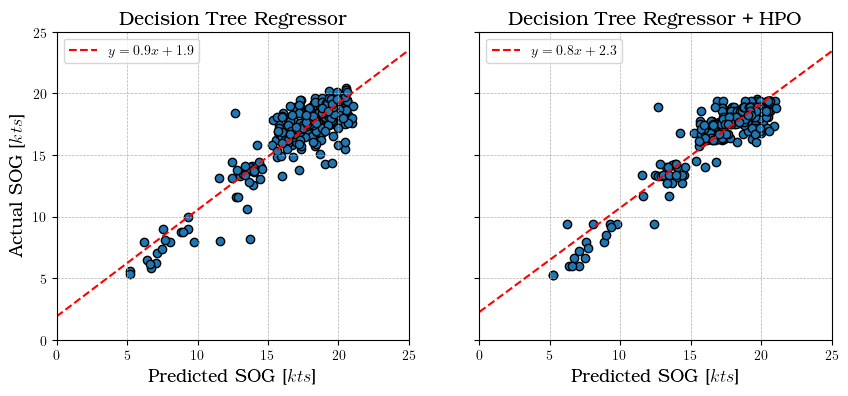

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_dtr_ftr,'Decision Tree Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_dtr_hpov,'Decision Tree Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8641250686489151
y = 0.8 * x + 2.2
0.8669620381079686
y = 0.8 * x + 2.3


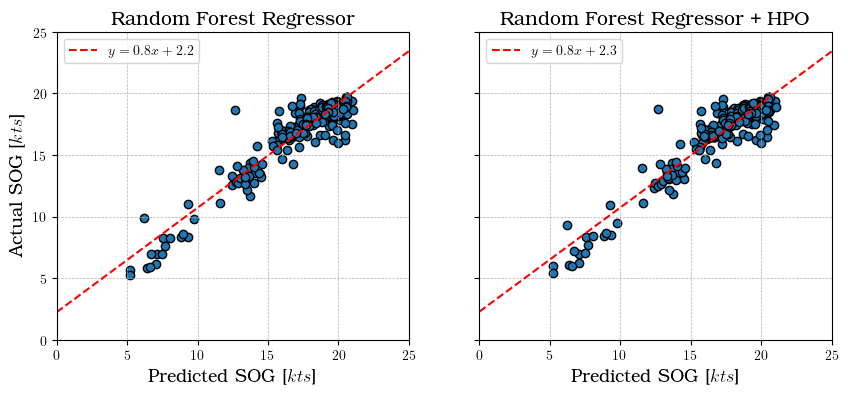

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_rfr_ftr,'Random Forest Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_rfr_hpov,'Random Forest Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

0.8743301165173356
y = 0.9 * x + 2.2
0.8731763195782185
y = 0.8 * x + 2.3


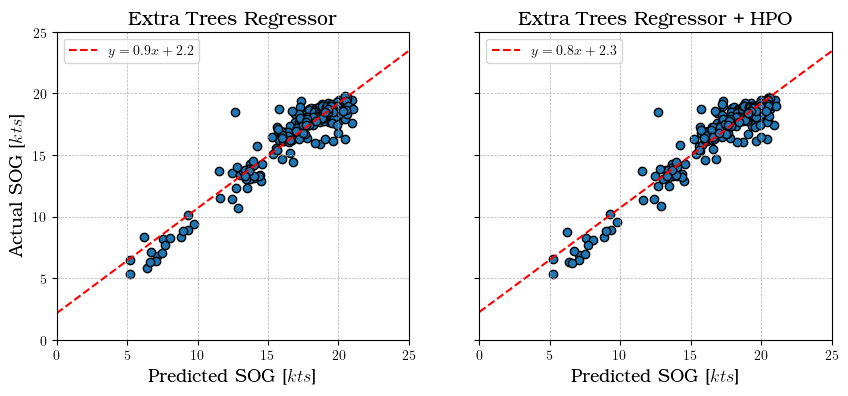

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
pred_plot(model_etr,'Extra Trees Regressor',x_date,y_date)
plt.sca(axes[1])
pred_plot(model_etr_hpov,'Extra Trees Regressor + HPO',x_date,y_date)
plt.ylabel("")
plt.show()

Evaluation using Cross Validation

<Figure size 500x300 with 0 Axes>

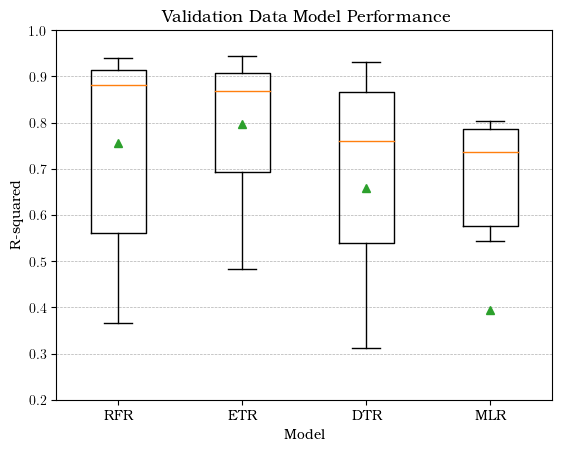

In [72]:
scores_test = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

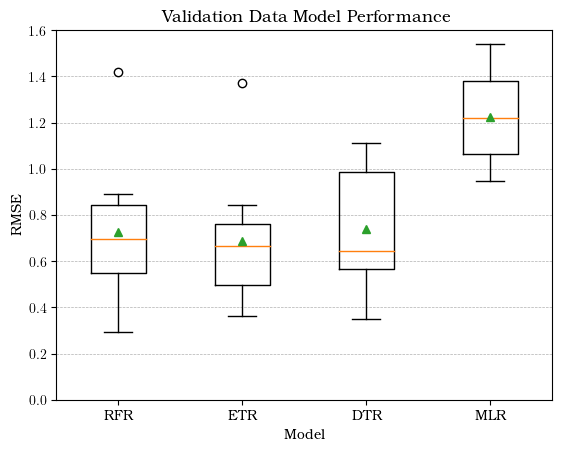

In [73]:
scores_test = [-RMSE_rf,-RMSE_et,-RMSE_dt,-RMSE_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Validation Data Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
plt.boxplot(scores_test,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR','MLR'])
plt.show()

Optimization comparison

<Figure size 500x300 with 0 Axes>

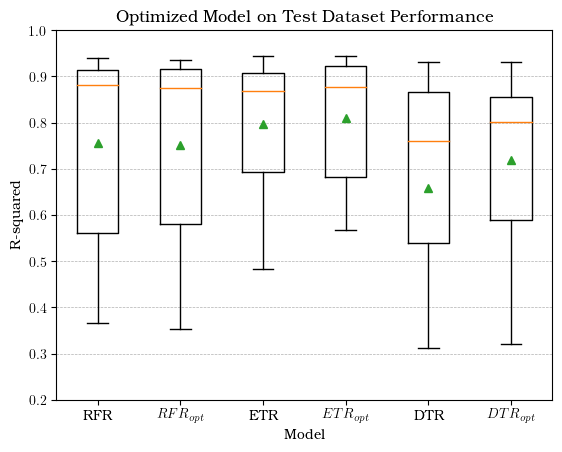

In [74]:
scores_opt = [r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model on Test Dataset Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

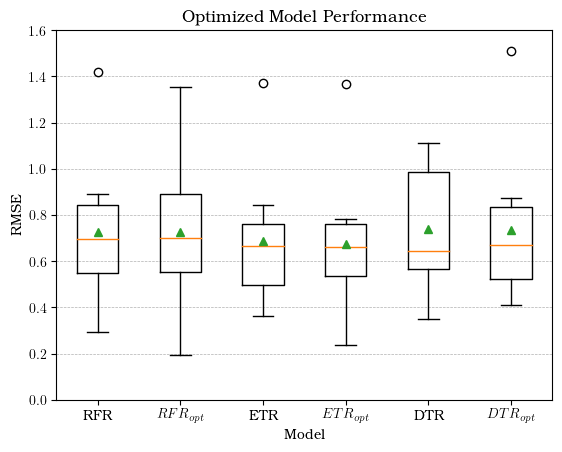

In [75]:
rmse_opt = [-RMSE_rf,-RMSE_rfo,-RMSE_et,-RMSE_eto,-RMSE_dt,-RMSE_dto]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                    r'ETR', r'$ETR_{opt}$',
                    r'DTR',r'$DTR_{opt}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

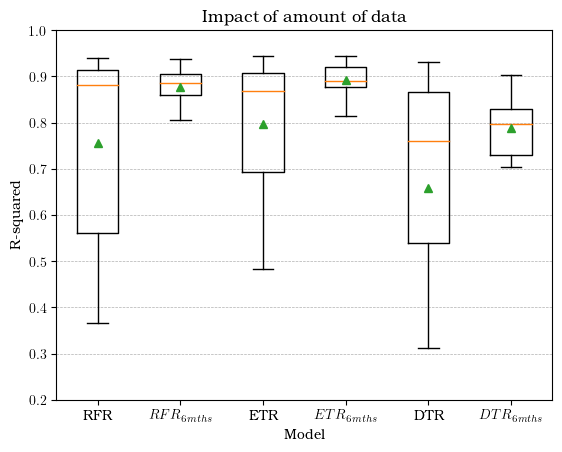

In [76]:
scores_opt = [r2_rf,r2_rfc,r2_et,r2_etc,r2_dt,r2_dtc]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Impact of amount of data")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.ylim(0.2,1.0)
plt.yscale('linear')
ax.boxplot(scores_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
                    r'ETR', r'$ETR_{6mths}$',
                    r'DTR',r'$DTR_{6mths}$'])
plt.show()

<Figure size 500x300 with 0 Axes>

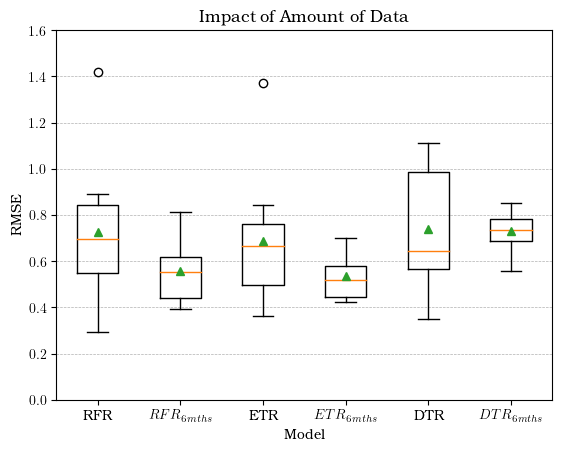

In [77]:
rmse_opt = [-RMSE_rf,-RMSE_rfc,-RMSE_et,-RMSE_etc,-RMSE_dt,-RMSE_dtc]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Impact of Amount of Data")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0,1.6)
ax.boxplot(rmse_opt,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels([r'RFR', r'$RFR_{6mths}$',
                    r'ETR', r'$ETR_{6mths}$',
                    r'DTR',r'$DTR_{6mths}$'])
plt.show()

In [78]:
# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c

STW Calculation

In [890]:
def label_predict(model,test_features):
    predictions = model.predict(test_features)
    return predictions

# # With more data 

ydate_pred = label_predict(model_etr_hpov,x_date_c)
ydate_pred_rf = label_predict(model_rfr_hpov,x_date_c)
ydate_pred_dt = label_predict(model_dtr_hpov,x_date_c)
ydate_pred_mlr = label_predict(model_mlr_ftr,x_date_c)
dfprog_sog = pd.Series(y_date_c,name="sog_act").to_frame()
dfprog_sog["gamma"] = pd.concat([dfdate6tr["truenorthcurrentdir"],df_months6["True North Current Direction"]])
dfprog_sog["nwinddir"] = pd.concat([dfdate6tr["truenorthwinddir"],df_months6["True North Wind Direction"]])
dfprog = pd.concat([x_date_c,dfprog_sog],axis=1)
dfprog.head(n=10)

# Normal test data

# ydate_pred = label_predict(model_etr,x_date)
# ydate_pred_rf = label_predict(model_rfr_hpov,x_date)
# ydate_pred_dt = label_predict(model_dtr_hpov,x_date)
# ydate_pred_mlr = label_predict(model_mlr_ftr,x_date)
# dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
# dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
# dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]
# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# dfprog.head(n=10)

# Global
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["sog_pred_rf"] = ydate_pred_rf
dfprog_sog["sog_pred_dt"] = ydate_pred_dt
dfprog_sog["sog_pred_mlr"] = ydate_pred_mlr

print(dfprog_sog)

        sog_act       gamma    nwinddir   sog_pred  sog_pred_rf  sog_pred_dt  \
119   18.998906  184.345879   21.771601  18.378565    18.502608    18.548179   
120   19.334278  199.414773   25.671971  18.451394    18.685107    18.548179   
121   18.911047  199.442652   32.436488  18.381229    18.547404    18.548179   
122   13.854933  189.415252   50.510505  14.118469    13.942330    14.284119   
126    9.305198  180.552404   74.157471  10.229631    10.907485     9.363115   
...         ...         ...         ...        ...          ...          ...   
7616  18.313552   72.022214  187.343749  17.852130    18.128018    18.081634   
7531  17.496387  317.622158  186.262307  17.141248    17.613578    17.530308   
7756  18.487548  353.213436  173.215990  18.957175    19.017735    18.857193   
6882  16.092160   58.533324  160.792593  16.400831    16.441117    16.755747   
1609  17.514406   59.505808  212.637673  18.545444    18.766208    18.018347   

      sog_pred_mlr  
119      17.686435

In [891]:
dfprog_sog.describe()

,sog_act,gamma,nwinddir,sog_pred,sog_pred_rf,sog_pred_dt,sog_pred_mlr
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,17.102082,149.782545,198.249227,16.947826,16.955467,16.944727,16.922029
std,3.203170,100.909434,91.109375,2.940857,2.947053,2.950325,2.616524
min,5.087138,0.112383,1.201077,5.366780,5.419481,5.274447,4.188902
25%,16.700126,76.381772,138.432564,16.737750,16.668734,16.673820,17.072454
50%,18.055400,119.217165,204.256134,18.000733,18.030284,18.018347,17.666107
75%,18.955901,220.698474,274.916339,18.603330,18.596668,18.548179,18.002078
max,21.031230,359.450078,359.808804,19.789562,19.853571,19.970330,26.956182


In [892]:
def sog_corr(sog,gamma,heading,current_speed):
    # Conversion of predicted SOG to m/s
    vgms = sog/1.9438
    rad_gamma = np.deg2rad(gamma)
    rad_cog = np.deg2rad(heading)
    # Calculation of the predicted x-component of SOG

    vgx = vgms * np.sin(rad_cog)
    vcx = current_speed * np.sin(rad_gamma)
    stw_x = vgx - vcx

    # Calculation of the predicted y-component of SOG 

    vgy = vgms * np.cos(rad_cog)
    vcy = current_speed * rad_gamma
    stw_y = vgy - vcy

    vwms_p = np.sqrt(stw_x**2 + stw_y**2)
    stw_pred = vwms_p*1.9438

    return stw_pred

In [893]:
# Predicted SOG from ET model

stw_pred_et = sog_corr(dfprog_sog['sog_pred'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

dfprog['stw_pred'] = stw_pred_et

In [894]:
# Predicted SOG from RF model

stw_pred_rf = sog_corr(dfprog_sog['sog_pred_rf'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

dfprog['stw_pred_rf'] = stw_pred_rf

In [895]:
# Predicted SOG from DT model

stw_pred_dt = sog_corr(dfprog_sog['sog_pred_dt'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

dfprog['stw_pred_dt'] = stw_pred_dt

In [896]:
# Predicted SOG from MLR model

stw_pred_mlr = sog_corr(dfprog_sog['sog_pred_mlr'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

dfprog['stw_pred_mlr'] = stw_pred_mlr

In [897]:
# Actual SOG

stw_pred_act = sog_corr(dfprog_sog['sog_act'],dfprog['gamma'],dfprog['heading'],dfprog['curspeed'])

dfprog['stw_act'] = stw_pred_act

In [898]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir,sog_act,gamma,nwinddir,stw_pred,stw_pred_rf,stw_pred_dt,stw_pred_mlr,stw_act
count,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000
mean,283.534402,3.605842,284.129738,0.726549,5.240969,194.650565,186.237389,6.253647,0.095217,85.844947,86.536784,94.070907,17.102082,149.782545,198.249227,16.992895,17.000508,16.989863,16.967098,17.146964
std,6.912233,0.865156,5.819622,0.498002,0.183145,85.907146,88.301351,2.969436,0.068211,56.632674,57.392576,56.305226,3.203170,100.909434,91.109375,2.925213,2.933478,2.936666,2.621385,3.185130
min,264.076782,1.915993,273.725098,0.070604,4.742665,69.768055,67.902386,0.248587,0.002006,0.029076,0.261234,0.200645,5.087138,0.112383,1.201077,5.338676,5.391370,5.245086,4.159747,5.169712
25%,277.007629,2.995353,278.471619,0.364545,5.110051,102.323533,100.789873,4.001141,0.046300,32.655606,29.536158,39.061972,16.700126,76.381772,138.432564,16.747624,16.702637,16.683877,17.100474,16.699758
50%,283.978760,3.491338,284.216065,0.616267,5.289037,181.882405,124.165565,5.937858,0.077106,80.433801,82.094939,99.279324,18.055400,119.217165,204.256134,18.049648,18.081126,18.047426,17.673733,18.096283
75%,289.869324,4.128581,289.843872,0.933939,5.379135,281.582587,278.498995,8.241529,0.127469,139.557005,142.211155,145.432793,18.955901,220.698474,274.916339,18.651868,18.661752,18.601701,18.058262,18.989255
max,295.713379,6.549616,294.732666,3.187404,5.660894,319.851509,305.693183,15.086706,0.460297,179.849755,179.682694,179.918071,21.031230,359.450078,359.808804,19.991090,19.972499,20.761669,28.062130,21.800027


Holtrop Mennen FOC function

In [899]:
def foc_fun(stw,T_dyn,windspeed,truewindir,H_s,truewavedir):
    # Ship Information, that are readily available in ship specification
    loa = 158 # ship overall length
    lwl = 144.8 # ship waterline length, m
    lpp = 0.97*lwl # ship perpendicular length , m, according to information
    B = 24.5 # Ship breadth, m
    depth = 13.8 # Ship depth. m
    T_n = 5.85 # Nominal max draught , m
    # T_n = 5.7 # Nominal design draught , m
    dwt = 5110 # ship dead weight , t
    V_n = 17.7 # ship design speed, knots

    # Environmental Constants

    g = 9.805 # gravity, kg/ms^2 
    rho_sea = 1025 # kg/m3
    nu_sea = 0.00000118 # Dynamic viscosity of sea m^2/s
    rho_air = 1.25 # density air 

    # Any other additional ship parameters beyond here are approximated based on literature review.

    # Convert STW to m/s, stw with only current correction

    stw_ms = stw / 1.94384

    # Switch between actual and predicted here 
    # Calculation for Block coefficient,C_b, according to Schneekluth and Bertram 1998
    # Then Froude number is required

    V_n = 17.7/1.94384
    Fr_n = V_n / math.sqrt(g*lwl)
    # print(f"Froude Number {Fr_n:0.4f}")

    C_b = -4.22 + 27.8*math.sqrt(Fr_n) - 39.1*Fr_n + 46.6*(Fr_n)**3
    # print(f"C_b {C_b:0.4f}")

    # calculation for midship section coefficient, C_m according to Jensen from Birk

    C_m = 1 / (1+(1-C_b)**3.5)
    # print(f"C_m {C_m:0.4f}")

    # prismatic coefficient C_p can be calculated according to Biran

    C_p = C_b/C_m 
    # print(f"C_p {C_p:0.4f}")

    # Displacement calculation according to Barras 

    dsp = C_b * lwl * B * T_n

    # print(f"dsp {dsp:0.4f} m^3")

    # coefficient c14 to account for stern shape according to holtrop mennen

    C_stern = 10 # assume u shaped stern
    c14 = 1 + 0.011*C_stern 
    
    # print(f"c14 {c14:0.4f}")

    # Calculate length of run according to holtrop mennen

    # lcb = -2/100 # according to Barras
    lcb = -(0.44*Fr_n - 0.094) # according to Guldhammer and Harvald

    # L in holtrop mennen is lwl

    lr = lwl*(1-C_p+(0.06*C_p*lcb/(4*C_p-1)))

    # print(f"lr {lr:0.4f} m")

    # now the (1+k1) can be calculated

    k1a = 0.487118*c14*(B/lwl)**1.06806
    k1b = (T_dyn/lwl)**0.46106
    k1c = (lwl/lr)**0.121563
    k1d = (lwl**3/dsp)**0.36486
    k1e = (1-C_p)**-0.604247

    k1_const = 0.93 + k1a*k1b*k1c*k1d*k1e

    # print(f"k1_const {k1_const.mean():0.4f}")

    # Calculate Reynold number and Coefficient of Friction C_f. Here, the C_f will be dynamic and depend on the velocity of the ship

    Re =( stw_ms * lwl ) / nu_sea
    C_f = 0.075 / (np.log10(Re-2)**2)

    # print(f"Mean Reynold Number {Re.mean():0.2f}")
    # print(f"Mean Coefficient of friction {C_f.mean():0.6f}")
    
    # Calculate the appendage area of bare hull S_bh
    # Formula according to Holtrop Mennen

    # Calculate the waterplane area coefficient 
    # Formula according to Schneekluth and Bertram

    C_wp = (1+2*C_b)/3
    # print(f"C_wp {C_wp:0.4f}")

    # Calculate transverse bulb area A_bt, Transom area A_t and immersed midship section area A_m according to Kim 2019

    # dfprog['A_m'] = B*dfprog['draught']*C_m
    # Borrow estimation of Am from Guldahmmer and Harvald
    A_m = dsp/(lpp*C_p)
    A_t = 0.051 * A_m
    A_bt = 0.085*A_m # From approximation of Kracht78, Similar to Charcalis
    # print(f"A_m {A_m:0.2f} m^2")
    # print(f"A_t {A_t:0.2f} m^2")
    # print(f"A_bt {A_bt:0.2f} m^2")

    sbh_a = lwl*(2*T_dyn+B)*math.sqrt(C_m)
    sbh_b = 0.453
    sbh_c = 0.4425*C_b
    sbh_d = 0.2862*C_m
    sbh_e = 0.003467*(B/T_dyn)
    sbh_f = 0.3696*C_wp
    sbh_g = 2.38*A_bt/C_b

    S_bh = sbh_a*(sbh_b+sbh_c-sbh_d+sbh_e+sbh_f)+sbh_g

    # print(f"S_bh {S_bh.mean():0.2f} m^2")

    # Calculate R_f

    R_f = 0.5 * rho_sea * stw_ms**2 * C_f * S_bh * k1_const

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Frictional Resistance {R_f.mean():0.2f} N")
    
    # Calculate resistance due to appendage

    # Assume S_app
    # Taken from Holtrop Mennen worked example
    # S_app = 50 # m^2 

    # Calculation of appendage area according to Hollenbach method, the formula is for twin screw ship

    # Lower limit
    S_app_lo = S_bh.mean()*(0.028+0.01*math.exp(-(lpp*T_n)/1000))

    # Upper limit
    S_app_hi = S_bh.mean()*(0.0325+0.045*math.exp(-(lpp*T_n)/1000))

    # print(f"S_app between {S_app_lo:.02f} and {S_app_hi:.02f} according to Hollenbach")

    # The following appendage area are scaled from the picture of the ship
    # Constant k here means (1+k_2) !

    D_shaft = 0.55 # m, approx
    l_shaft = 13.54 # m, approx

    S_app_shaft = math.pi * D_shaft * l_shaft
    k2_shaft = 2   

    h_rudder = 4.06 #m, approx
    B_rudder = 1.99 #m, approx
    S_app_rudder = 2 * h_rudder * B_rudder #m, two side
    k2_rudder = 3

    h_skeg = 4.41 #m, approx
    l_skeg = 26.23 #m, approx
    S_app_skeg =  h_skeg * l_skeg #two side
    k2_skeg = 0.75

    S_app = S_app_shaft + S_app_rudder + S_app_skeg

    k2_const = (k2_shaft*S_app_shaft + k2_rudder*S_app_rudder + k2_skeg*S_app_skeg)/S_app

    # print(f"Wetted area of hull is {S_bh.mean():0.2f}")
    # print(f"(1+k2) equivalent {k2_const:0.2f}")
    # print(f"Total Appendage area is {S_app:0.2f}")
    # # from holtrop mennen, take case of twin screw
    # k2_const = 2.8

    # Add resistance due to Bow Thrusters

    d_th = 2.15 #m, approx

    # Use formula from Hollenach
    C_dth = 0.003 + 0.003*((10*d_th/T_n)-1)
    # C_dth = 0.003 # The picture shows that the thruster are fairly parallel to midship area
    # There are two bow thruster in this ship
    R_th = rho_sea*stw_ms**2*math.pi*d_th**2*C_dth

    # print(f"Friction due to bow thrusters {R_th.mean():0.2f} N")

    R_app = (0.5 * rho_sea * stw_ms**2 * C_f * S_app *k2_const) + 2*R_th

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Appendage Friction {R_app.mean():0.2f} N")

    # Calculate wave-making and wave-breaking resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")
    # print(f"B/lwl = {B/lwl:0.2f}")
    # print(f"lwl^3/displacemt = {lwl**3/dsp:0.2f}")
    # print(f"C_p = {C_p:0.4f}")


    c7 = B/lwl
    T_fwd = T_dyn # See reasoning from Rakke16 
    h_b = 0.6*T_n # must not exceed 0.6 T_f, here T_n = T_f (design), reasong and coefficient value taken from Rakke

    # All formulas here are listed by Holtrop Mennen

    c3 = 0.56 * A_bt**1.5 / (B*T_dyn*(0.31*np.sqrt(A_bt)+T_fwd-h_b))
    c2 = np.exp(-1.89*np.sqrt(c3))
    c5 = 1 - 0.8*(A_t/(B*T_dyn*C_m))
    lambda_const = (1.446 * C_p) - 0.03*(lwl/B)
    c16 = 8.07981*C_p - 13.8673*C_p**2 + 6.984388*C_p**3
    m_1 = 0.0140407 * (lwl/T_dyn) - 1.75254*(dsp**(1/3)/lwl) -  4.79323*(B/lwl) - c16
    c15 = -1.69385

    # Use dynamic Froude here to refect the actual resistance due to ship movement 

    Fr_n_dyn = stw_ms / math.sqrt(g*lwl)
    # Updated formula use m_4
    m4 = 0.4 * c15 * np.exp(-0.034*Fr_n_dyn **-3.29)

    i_e = 1 + 89*math.exp(-(lwl/B)**0.80856*(1-C_wp)**0.30484*(1-C_p-0.0225*lcb)**0.6367*(lr/B)**0.34574*((100*dsp)/lwl**3)**0.16302)
    c1 = 2223105 * c7**3.78613 * (T_dyn/B)**1.07961*(90-i_e)**-1.37565
    d = -0.9

    # Use updated formula with m4

    R_w = c1*c2*c5*dsp*g*rho_sea*np.exp(m_1*Fr_n_dyn **d+m4*np.cos(lambda_const*Fr_n_dyn **-2))

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Wave resistance {R_w.mean():0.2f} N")

    # Calculate Resistance due to Bulbous Bow
    # Calculate effect of forward sinkage h_f and local wave height at bow h_w

    P_b = 0.56*np.sqrt(A_bt)/(T_fwd-1.5*h_b)
    Fn_i = stw_ms / np.sqrt(g*(T_fwd-h_b-0.25*np.sqrt(A_bt))+0.15*stw_ms**2)
    R_b = 0.11 * np.exp(-3*P_b**-2)*Fn_i**3*A_bt**1.5*rho_sea*g/(1+Fn_i**2)

    # print(f"Emergence of bulb Pb {P_b.mean():0.4f}")
    # print(f"Immersion Froude number Fn_i {Fn_i.mean():0.2f}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to bulbous bow {R_b.mean():0.2f} N")    

    #Calculate Transom Resistance 

    Fn_tr = stw_ms / np.sqrt(2*g*A_t/(B+(B*C_wp)))

    # print(f"Froude for Transom {Fn_tr.mean():0.4f}")

    # Use condition to calculate Froude due to transom

    cond_Fn_tr = [Fn_tr < 5 ]
    cond_c6 = [0.2*(1-0.2*Fn_tr)]

    c6 = np.select(cond_Fn_tr,cond_c6,0)
    R_tr = 0.5*rho_sea*10**2*A_t*c6

    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Resistance due to transom {R_tr.mean():0.2f} N")

    # Model ship correlation resistance

    # print("Ratio check to ensure correct formula is used for Holtrop Mennen")

    cond_Tf_lwl = [(T_fwd/lwl) <= 0.04 ]
    cond_c4 = [T_fwd/lwl]
    c4 = np.select(cond_Tf_lwl,cond_c4,0.04)

    C_a = 0.00546*(lwl+100)**-0.16 - 0.002 + 0.003*math.sqrt(lwl/7.5)*C_b**4*c2*(0.04-c4)

    R_a = 0.5*rho_sea*stw_ms**2*C_a*(S_bh+S_app)

    # print(f"C_a {C_a.mean()}")
    # print(f"Mean STW {stw.mean():0.2f} kt")
    # print(f"Correlation allowance resistance {R_a.mean():0.2f} N")

    # Calculate Additional Resistance, consist of wind resistance and wave resistance
    # Calculate Apparent velocities and Apparent Angle 

    V_aw = np.sqrt(windspeed**2 + stw_ms**2 + 2*windspeed*stw_ms*np.cos(np.deg2rad(truewindir)))

    awa_c1 = (windspeed/V_aw)*np.sin(np.deg2rad(truewindir))

    # Epsilon is Apparent Wind Angle AWA

    epsilon = np.rad2deg(np.arcsin(awa_c1))

    # Values and method from Blendermann

    C_DlAf = 0.45
    A_f = 325.3
    A_l = 2125.8
    C_Dt = 0.9
    delta = 0.8
    C_Dl = C_DlAf * A_f / A_l
    L_bwl = 43.75 # m, acquired from picture

    Raa_const1 = (rho_air/2) * V_aw**2 * A_l * C_Dl
    Raa_const2 = np.cos(np.deg2rad(epsilon))
    Raa_const3 = 1 - (delta/2) * ((1-(C_Dl/C_Dt))*(np.sin(np.deg2rad(2*epsilon)))**2)

    R_aa = Raa_const1 * Raa_const2 / Raa_const3 

    # print(f"Mean wind resistance Blendermann {R_aa.mean():0.2f}N")

    # Calculate Wave Resistance according to STAWAVE-1

    Rawl = 1/16 * rho_sea * g * H_s**2 * math.sqrt(B/L_bwl)

    condwave = [truewavedir<=45]
    choicewave = [Rawl]

    R_awl = np.select(condwave,choicewave,0)

    # print(f"Mean wave resistance STAWAVE-1 {R_awl.mean():0.2f} N")

    R_tot = (R_f + R_app + R_w + R_b + R_a + R_tr  + R_aa + R_awl)/1e3 

    # Calculate Efficiencies

    # Diameter value for ship estimated from Bertram 

    # D = 0.215*16 #m 
    # Revised D, 08.07.23
    D = 4 # m, from flyer

    # Update C_v formula

    C_v = (k1_const*R_f + R_app + R_a) / (0.5*rho_sea*stw_ms**2*(S_bh+S_app))
    w = 0.3095 * C_b + 10*C_v*C_b - (0.23*D)/np.sqrt(B*T_dyn) 
    t = 0.325*C_b - 0.1885*D/np.sqrt(B*T_dyn)
    eff_h = (1-t) / (1-w)
    eff_r = 0.9737 + 0.111*(C_p - 0.225*lcb) - 0.06325*lcb
    eff_s = 0.99 # Set according to holtrop mennen and man
    eff_o = 0.75 # Approximation from Wageningen Line from Breslin94, since Holtrop perform their measurement in Wageningen basin 

    eff_tot = eff_h* eff_r* eff_s*eff_o # consider sea margin

    # print(f"Total Efficiency {eff_tot.mean():0.3f}")

    # Calculate power and FOC

    P_b = (R_tot * stw_ms)/eff_tot # in kW
    SFOC = 169.4 # g/kWh, taken from datasheet Waertsilla 8V31
    FOC = (P_b * SFOC)/1e6 # get FOC t/h

    print("Summary of important results")
    
    print(f"Ship Displacement {dsp:0.4f} m^3")
    print(f"Prismatic coefficient C_p {C_p:0.4f}")
    print(f"Midship coefficient C_m {C_m:0.4f}")
    print(f"Block coefficient C_b {C_b:0.4f}")
    print(f"Design Froude Number Fr_n {Fr_n:0.4f}")
    print(f"Mean STW {stw.mean():0.2f} kt")
    print(f"Max STW {stw.max():0.2f} kt")
    print(f"Average frictional Resistance R_f {R_f.mean()/1e3:0.3f}kN")
    print(f"Average appendage friction R_app {R_app.mean()/1e3:0.3f}kN")
    print(f"Average wave making (calm) resistance R_w {R_w.mean()/1e3:0.3f}kN")
    print(f"Average bulbous bow resistance R_b {R_b.mean()/1e3:0.3f}kN")
    print(f"Average transom resistance R_t {R_tr.mean()/1e3:0.3f}kN")
    print(f"Average model correlation resistance R_a {R_a.mean()/1e3:0.3f}kN")
    print(f"Average wind resistance (Blendermann) R_aa {R_aa.mean()/1e3:0.3f}kN")
    print(f"Average wave resistance R_awl {R_awl.mean()/1e3:0.3f}kN")
    print(f"Average Total Efficiency {eff_tot.mean():0.3f}")
    print(f"Average Power {P_b.mean():0.3f} kW")
    print(f"Max Power {P_b.max():0.3f} kW")
    print(f"Average Fuel Consumption per hour {FOC.mean():0.3f} T")

    return R_f,R_app,R_w,R_b,R_tr,R_a,R_aa,R_awl,R_tot,eff_tot,P_b,FOC


Results from ETR

In [900]:
Rf_pred,R_app_pred,R_w_pred,R_b_pred,R_tr_pred,R_a_pred,R_aa_pred,R_awl_pred,R_tot_pred,eff_tot_pred,P_b_pred,FOC_pred = foc_fun(dfprog['stw_pred'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Design Froude Number Fr_n 0.2417
Mean STW 16.99 kt
Max STW 19.99 kt
Average frictional Resistance R_f 173.498kN
Average appendage friction R_app 32.553kN
Average wave making (calm) resistance R_w 91.020kN
Average bulbous bow resistance R_b 70.952kN
Average transom resistance R_t 5.188kN
Average model correlation resistance R_a 43.849kN
Average wind resistance (Blendermann) R_aa 12.497kN
Average wave resistance R_awl 0.112kN
Average Total Efficiency 0.767
Average Power 5103.932 kW
Max Power 8254.068 kW
Average Fuel Consumption per hour 0.865 T


Results from RFR

In [901]:
Rf_pred_rf,R_app_pred_rf,R_w_pred_rf,R_b_pred_rf,R_tr_pred_rf,R_a_pred_rf,R_aa_pred_rf,R_awl_pred_rf,R_tot_pred_rf,eff_tot_pred_rf,P_b_pred_rf,FOC_pred_rf = foc_fun(dfprog['stw_pred_rf'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Design Froude Number Fr_n 0.2417
Mean STW 17.00 kt
Max STW 19.97 kt
Average frictional Resistance R_f 173.664kN
Average appendage friction R_app 32.586kN
Average wave making (calm) resistance R_w 91.391kN
Average bulbous bow resistance R_b 70.962kN
Average transom resistance R_t 5.192kN
Average model correlation resistance R_a 43.894kN
Average wind resistance (Blendermann) R_aa 12.512kN
Average wave resistance R_awl 0.112kN
Average Total Efficiency 0.767
Average Power 5115.166 kW
Max Power 8219.890 kW
Average Fuel Consumption per hour 0.867 T


Results from DTR

In [902]:
Rf_pred_dt,R_app_pred_dt,R_w_pred_dt,R_b_pred_dt,R_tr_pred_dt,R_a_pred_dt,R_aa_pred_dt,R_awl_pred_dt,R_tot_pred_dt,eff_tot_pred_dt,P_b_pred_dt,FOC_pred_dt = foc_fun(dfprog['stw_pred_dt'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Design Froude Number Fr_n 0.2417
Mean STW 16.99 kt
Max STW 20.76 kt
Average frictional Resistance R_f 173.476kN
Average appendage friction R_app 32.549kN
Average wave making (calm) resistance R_w 91.084kN
Average bulbous bow resistance R_b 70.938kN
Average transom resistance R_t 5.200kN
Average model correlation resistance R_a 43.844kN
Average wind resistance (Blendermann) R_aa 12.481kN
Average wave resistance R_awl 0.112kN
Average Total Efficiency 0.767
Average Power 5104.442 kW
Max Power 9813.641 kW
Average Fuel Consumption per hour 0.865 T


Results from MLR 

In [903]:
Rf_pred_mlr,R_app_pred_mlr,R_w_pred_mlr,R_b_pred_mlr,R_tr_pred_mlr,R_a_pred_mlr,R_aa_pred_mlr,R_awl_pred_mlr,R_tot_pred_mlr,eff_tot_pred_mlr,P_b_pred_mlr,FOC_pred_mlr = foc_fun(dfprog['stw_pred_mlr'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Design Froude Number Fr_n 0.2417
Mean STW 16.97 kt
Max STW 28.06 kt
Average frictional Resistance R_f 172.161kN
Average appendage friction R_app 32.278kN
Average wave making (calm) resistance R_w 86.106kN
Average bulbous bow resistance R_b 71.167kN
Average transom resistance R_t 4.269kN
Average model correlation resistance R_a 43.472kN
Average wind resistance (Blendermann) R_aa 12.485kN
Average wave resistance R_awl 0.112kN
Average Total Efficiency 0.767
Average Power 4971.317 kW
Max Power 29766.901 kW
Average Fuel Consumption per hour 0.842 T


Actual Results

In [904]:
Rf_act,R_app_act,R_w_act,R_b_act,R_tr_act,R_a_act,R_aa_act,R_awl_act,R_tot_act,eff_tot_act,P_b_act,FOC_act = foc_fun(dfprog['stw_act'],dfprog['draught'],dfprog['windspeed'],dfprog['truewinddir'],dfprog['windwaveswellheight'],dfprog['truewavedir'])

Summary of important results
Ship Displacement 13592.1413 m^3
Prismatic coefficient C_p 0.6707
Midship coefficient C_m 0.9764
Block coefficient C_b 0.6549
Design Froude Number Fr_n 0.2417
Mean STW 17.15 kt
Max STW 21.80 kt
Average frictional Resistance R_f 177.254kN
Average appendage friction R_app 33.293kN
Average wave making (calm) resistance R_w 101.986kN
Average bulbous bow resistance R_b 71.134kN
Average transom resistance R_t 5.448kN
Average model correlation resistance R_a 44.860kN
Average wind resistance (Blendermann) R_aa 12.690kN
Average wave resistance R_awl 0.112kN
Average Total Efficiency 0.767
Average Power 5403.418 kW
Max Power 11848.743 kW
Average Fuel Consumption per hour 0.915 T


In [905]:
stw_pred = dfprog['stw_pred']
stw_act = dfprog['stw_act']

In [906]:

def FOC_coeff_plot(stw_predicted,stw_actual,FOC_predicted,FOC_actual):

    slow_steam = 0.2*9760*(169.4/1e6)
    normal = 0.65*9760*(169.4/1e6)
    max_Pb = 9760*(169.4/1e6)

    # To predict FOC

    Xp = stw_predicted
    Yp = FOC_predicted

    Xa = stw_actual
    Ya = FOC_actual

    coefs_pred = np.polyfit(Xp, Yp, 4)
    coefs_act = np.polyfit(Xa, Ya, 4)


    print("Coefficients for FOC curve")
    print(coefs_pred)
    print(coefs_act)

    p_pred = np.poly1d(coefs_pred)
    p_act = np.poly1d(coefs_act)

    plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
    plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

    sorted_pred= np.sort(Xp)
    sorted_act= np.sort(Xa)

    plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = '-',color = 'b',
            label=rf'$y = ({coefs_pred[0]:.3G})x^4 {coefs_pred[1]:.3G}x^3 + {coefs_pred[2]:.3G}x^2 {coefs_pred[3]:.3G}x + {coefs_pred[4]:.3G}$') #p(X) evaluates the polynomial at X
#     plt.plot(sorted_act, p_act(sorted_act), linestyle = "-." , color = 'red',
#             label=rf'$y = ({coefs_act[0]:.3G})x^4 {coefs_act[1]:.3G}x^3 + {coefs_act[2]:.3G}x^2 {coefs_act[3]:.3G}x + {coefs_act[4]:.3G}$') #p(X) evaluates the polynomial at X
    plt.title("FOC Plot")
    plt.xlabel(r'STW [$knots$]', fontsize=13)
    plt.ylabel(r'FOC [$T/h$]', fontsize=13)

    plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
    plt.axhline(y=normal,linestyle = 'dotted',c='k')
    plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

    plt.text(6.1,1.1*slow_steam,'Slow Steaming',rotation=360)
    plt.text(6.1,1.03*normal,'Normal Crusing',rotation=360)
    plt.text(6.1,1.01*max_Pb,'Max Power',rotation=360)


    plt.xlim(6,21)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    # plt.legend(bbox_to_anchor=(0.5,-.4),loc="lower left")
    plt.legend(loc="lower left",bbox_to_anchor=(-0.025, -0.34))
    # plt.show()

    return coefs_act,coefs_pred


In [907]:
def Pb_plot(stw_predicted,stw_actual,Pb_predicted,Pb_actual):

        # To predict Power

        # According to 3rd IMO GHG study

        slow_steam = 0.2*9760
        normal = 0.65*9760
        max_Pb = 9760

        Xp = stw_predicted
        Yp = Pb_predicted

        Xa = stw_actual
        Ya = Pb_actual

        coefs_pred = np.polyfit(Xp, Yp, 4)
        coefs_act = np.polyfit(Xa, Ya, 4)

        print("Coefficients for power curve")
        print(coefs_pred)
        print(coefs_act)  
        
        p_pred = np.poly1d(coefs_pred)
        p_act = np.poly1d(coefs_act)   

        sorted_pred= np.sort(Xp)
        sorted_act= np.sort(Xa)
 
        plt.scatter(Xa, Ya,marker='o',linewidths=.8,edgecolors='orange',facecolor='none', label = 'Actual STW',s=12 )
        plt.scatter(Xp, Yp,marker='x',linewidths=.5,c='black',label = 'Predicted STW',s=12 )

        plt.plot(sorted_pred, p_pred(sorted_pred), linestyle = 'dashdot',color = 'b',
        label=rf'$y = {coefs_pred[0]:.3f}x^4 {coefs_pred[1]:.3f}x^3 + {coefs_pred[2]:.3f}x^2 {coefs_pred[3]:.3f}x + {coefs_pred[4]:.3f}$') #p(X) evaluates the polynomial at X

        plt.title("Predicted vs Actual")
        plt.xlabel(r'STW [$knots$]', fontsize=13)
        plt.ylabel(r'Brake Power [$kW$]', fontsize=13)

        plt.title("Power Plot")

        plt.axhline(y=slow_steam,linestyle = 'dotted',c='k')
        plt.axhline(y=normal,linestyle = 'dotted',c='k')
        plt.axhline(y=max_Pb,linestyle = 'dotted',c='k')

        plt.text(6.1,2100,'Slow Steaming',rotation=360)
        plt.text(6.1,6500,'Normal Crusing',rotation=360)
        plt.text(6.1,9900,'Max Power',rotation=360)


        plt.xlim(6,21)
        plt.ylim(0,12000)
        plt.grid(linestyle = '--', linewidth = 0.5)
        plt.legend(loc="lower left",bbox_to_anchor=(-.025, -0.34))

        # plt.show()

Coefficients for FOC curve
[ 3.71033862e-05 -1.36093343e-03  2.13036722e-02 -1.22633322e-01
  2.88743031e-01]
[ 5.15720483e-05 -2.05288521e-03  3.29585682e-02 -2.03545363e-01
  4.83282049e-01]
Coefficients for power curve
[ 2.19028254e-01 -8.03384550e+00  1.25759576e+02 -7.23927524e+02
  1.70450431e+03]
[ 3.04439482e-01 -1.21185668e+01  1.94560615e+02 -1.20156649e+03
  2.85290466e+03]


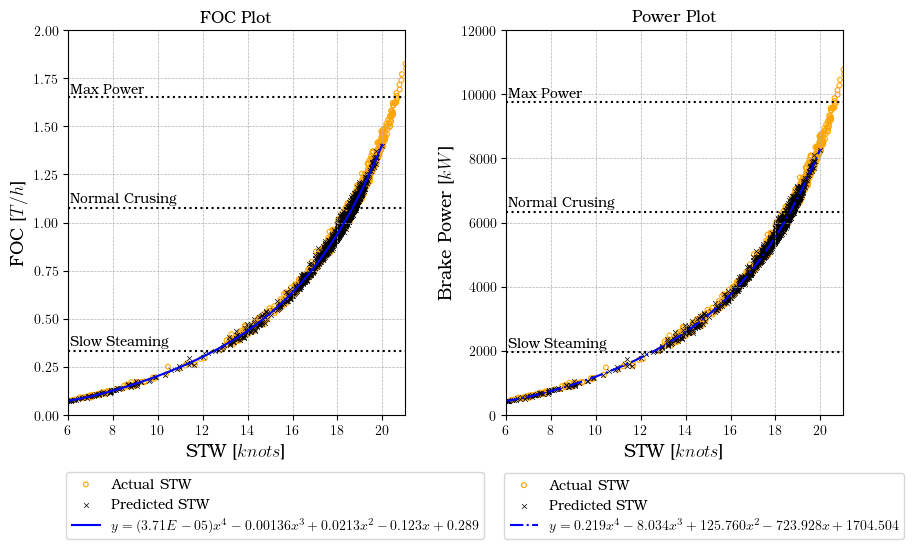

In [908]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act,coefs_pred = FOC_coeff_plot(stw_pred,stw_act,FOC_pred,FOC_act)
plt.sca(axes[1])
Pb_plot(stw_pred,stw_act,P_b_pred,P_b_act)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

plt.show()

Coefficients for FOC curve
[ 3.79773385e-05 -1.40221115e-03  2.19974070e-02 -1.27524613e-01
  3.00885341e-01]
[ 5.15720483e-05 -2.05288521e-03  3.29585682e-02 -2.03545363e-01
  4.83282049e-01]
Coefficients for power curve
[ 2.24187359e-01 -8.27751566e+00  1.29854823e+02 -7.52801732e+02
  1.77618265e+03]
[ 3.04439482e-01 -1.21185668e+01  1.94560615e+02 -1.20156649e+03
  2.85290466e+03]


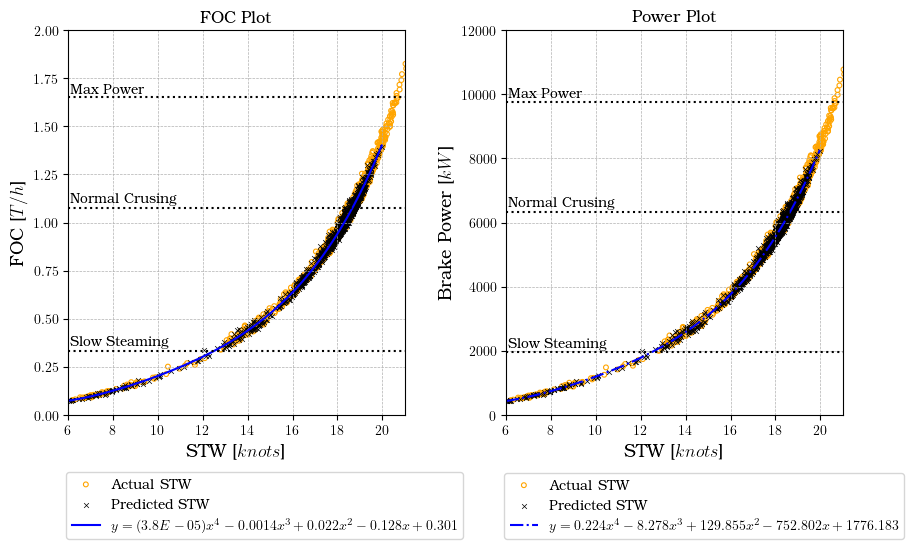

In [909]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_rf,coefs_pred_rf = FOC_coeff_plot(stw_pred_rf,stw_act,FOC_pred_rf,FOC_act)
plt.sca(axes[1])
Pb_plot(stw_pred_rf,stw_act,P_b_pred_rf,P_b_act)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

Coefficients for FOC curve
[ 3.82529018e-05 -1.41652125e-03  2.22400869e-02 -1.28998105e-01
  3.03247201e-01]
[ 5.15720483e-05 -2.05288521e-03  3.29585682e-02 -2.03545363e-01
  4.83282049e-01]
Coefficients for power curve
[ 2.25814060e-01 -8.36199088e+00  1.31287408e+02 -7.61500032e+02
  1.79012515e+03]
[ 3.04439482e-01 -1.21185668e+01  1.94560615e+02 -1.20156649e+03
  2.85290466e+03]


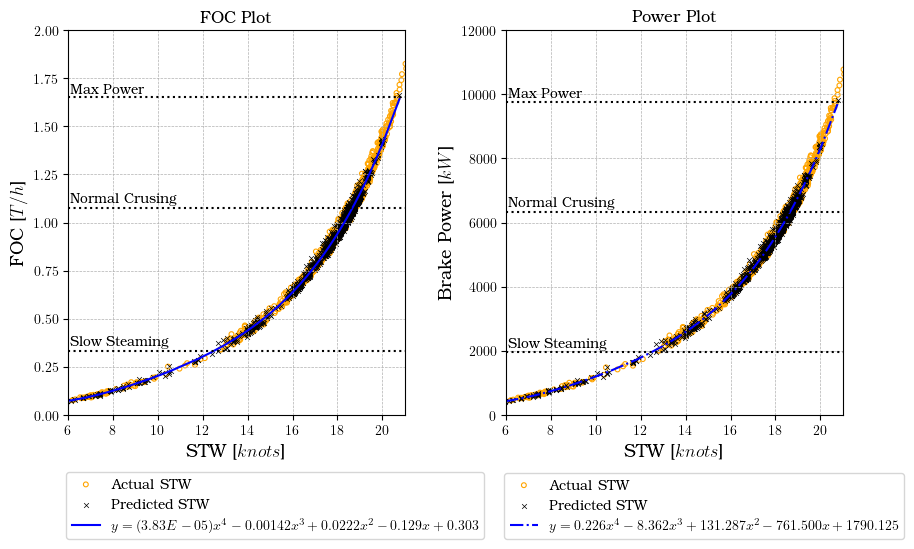

In [910]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_dt,coefs_pred_dt = FOC_coeff_plot(stw_pred_dt,stw_act,FOC_pred_dt,FOC_act)
plt.sca(axes[1])
Pb_plot(stw_pred_dt,stw_act,P_b_pred_dt,P_b_act)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

Coefficients for FOC curve
[-3.45735101e-08  5.44448280e-04 -1.31683185e-02  1.33783932e-01
 -3.66790437e-01]
[ 5.15720483e-05 -2.05288521e-03  3.29585682e-02 -2.03545363e-01
  4.83282049e-01]
Coefficients for power curve
[-2.04093921e-04  3.21398040e+00 -7.77350564e+01  7.89751662e+02
 -2.16523281e+03]
[ 3.04439482e-01 -1.21185668e+01  1.94560615e+02 -1.20156649e+03
  2.85290466e+03]


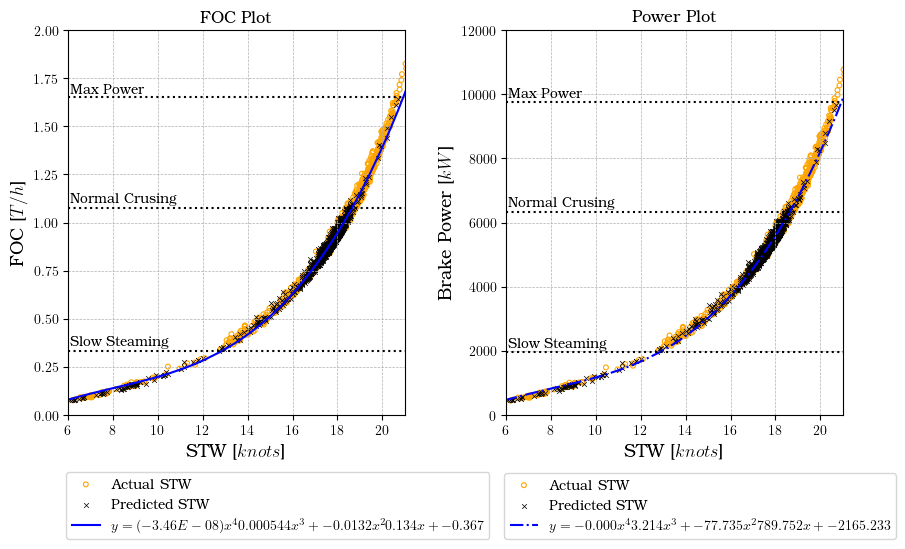

In [911]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)
plt.sca(axes[0])
coefs_act_mlr,coefs_pred_mlr = FOC_coeff_plot(stw_pred_mlr,stw_act,FOC_pred_mlr,FOC_act)
plt.sca(axes[1])
Pb_plot(stw_pred_mlr,stw_act,P_b_pred_mlr,P_b_act)
# plt.ylabel("")
plt.subplots_adjust(wspace=0.3)
plt.show()

In [912]:
import random

# # Simulate model performance by inserting arbitrary STW in knots

def generate_random_integers(min_value, max_value, n):
    random_numbers = [random.uniform(min_value, max_value) for _ in range(n)]
    return random_numbers
# speed range, 5-21 kts, simulate 18h journey time in a day over a month so (18*31)
v_stw_lst = generate_random_integers(5,21,558) 
v_stw = np.array(v_stw_lst)
print(v_stw)

# # Simulate one way trip

# v_stw_lst_day = [17.27621092,18.9989056,19.33427835,18.91104651,13.85493274]
# v_stw = np.array(v_stw_lst_day)


FOC_poly_act = coefs_act[0]*v_stw**4 + coefs_act[1] * v_stw**3 + coefs_act[2] * v_stw**2 + coefs_act[3]*v_stw + coefs_act[4]

# Get the model for each machine learning prediction approach

# pred is for ET
FOC_poly_pred = coefs_pred[0]*v_stw**4 + coefs_pred[1] * v_stw**3 + coefs_pred[2] * v_stw**2 + coefs_pred[3]*v_stw + coefs_pred[4]


[ 6.4626049  14.42075512 12.87861068 19.61587615 17.91123475 11.53295921
 20.57656728  5.84843226 11.55450741 15.27405252 14.84949214 10.8783397
  5.66596819 15.41638853 19.60216386 12.55294566 10.34521517 15.11990215
  5.63464148  9.64620034 20.80826516 17.49917994 12.10564912 18.97508554
 13.19910878 20.82066428 20.1023184  11.02515594 16.15749762  5.95913081
 20.92508749 18.75602941  9.74172283 18.99855009  6.18708386 16.16797892
  9.31045643 17.64328832  9.37344781 15.57939988 20.29212913 18.54829866
 11.09978088 11.89239332  9.94211539 13.31518316  7.75726532  8.52668202
 12.91822255 11.85261196  5.90616137 18.89215029 12.5855017   6.68564576
  5.57267727 16.32825526 13.3099909  16.92008845 17.20774238 13.87609765
  6.04337237 12.14250533 10.25170204 11.28876183 12.49823356 18.63689576
 14.10605998  7.11567079 14.74461724 15.44084982 19.50516465 18.50812586
  5.32489546  6.09330017 20.31449956 16.80331145 19.57939657  9.85721722
  6.57162521 13.64192016 12.97499393 13.09069424 11.

In [913]:
# for random forest

FOC_poly_pred_rf = coefs_pred_rf[0]*v_stw**4 + coefs_pred_rf[1] * v_stw**3 + coefs_pred_rf[2] * v_stw**2 + coefs_pred_rf[3]*v_stw + coefs_pred_rf[4]

In [914]:
# For decision tree

FOC_poly_pred_dt = coefs_pred_dt[0]*v_stw**4 + coefs_pred_dt[1] * v_stw**3 + coefs_pred_dt[2] * v_stw**2 + coefs_pred_dt[3]*v_stw + coefs_pred_dt[4]

In [915]:
# For MLR

FOC_poly_pred_mlr = coefs_pred_mlr[0]*v_stw**4 + coefs_pred_mlr[1] * v_stw**3 + coefs_pred_mlr[2] * v_stw**2 + coefs_pred_mlr[3]*v_stw + coefs_pred_mlr[4]

Polyfit model performance 

In [916]:
# This model defines the performance of the generated polyfit line from the model

def evaluate_FOC_poly(model,FOC_poly_act,FOC_poly_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_ply = r2_score(FOC_poly_act,FOC_poly_pred)
    expVar_ply = explained_variance_score(FOC_poly_act,FOC_poly_pred)
    MAE_ply = mean_absolute_error(FOC_poly_act,FOC_poly_pred)
    RMSE_ply = np.sqrt(mean_squared_error(FOC_poly_act,FOC_poly_pred))
    MAD_ply = median_absolute_error(FOC_poly_act,FOC_poly_pred)
    MAPE_ply = mean_absolute_percentage_error(FOC_poly_act,FOC_poly_pred)
    
    n = len(FOC_poly_act)
    num_params = 4 + 1 # 4th order model is best fit
    aic_ply = n * np.log(mean_squared_error(FOC_poly_act,FOC_poly_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic_ply:0.4f}")
    print(f"R^2 {Rsquared_ply:0.4f}")
    print(f"Explained Variance {expVar_ply:0.4f}")
    print(f"MSE {MAE_ply:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_ply:0.4f} T/h")
    print(f"MAD {MAD_ply:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_ply*100:0.4f} %")

In [917]:
evaluate_FOC_poly(model_etr_hpov,FOC_poly_act,FOC_poly_pred)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
AIC -5224.7829
R^2 0.9996
Explained Variance 0.9997
MSE 0.0055 T/h
RMSE FOC 0.0092 T/h
MAD 0.0034 T/h
MAPE FOC 1.3937 %


In [918]:
evaluate_FOC_poly(model_rfr_hpov,FOC_poly_act,FOC_poly_pred_rf)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -5307.1370
R^2 0.9997
Explained Variance 0.9997
MSE 0.0052 T/h
RMSE FOC 0.0085 T/h
MAD 0.0032 T/h
MAPE FOC 1.3327 %


In [919]:
evaluate_FOC_poly(model_dtr_hpov,FOC_poly_act,FOC_poly_pred_dt)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -5301.4982
R^2 0.9997
Explained Variance 0.9997
MSE 0.0051 T/h
RMSE FOC 0.0086 T/h
MAD 0.0031 T/h
MAPE FOC 1.2416 %


In [920]:
evaluate_FOC_poly(model_mlr_ftr,FOC_poly_act,FOC_poly_pred_mlr)

Model Performance of LinearRegression()
AIC -4190.3470
R^2 0.9974
Explained Variance 0.9980
MSE 0.0173 T/h
RMSE FOC 0.0232 T/h
MAD 0.0148 T/h
MAPE FOC 6.1029 %


Absolute model performance

In [921]:
# This function defines the model performance for the given stw range

def evaluate_FOC(model,FOC_act,FOC_pred):
    from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,explained_variance_score,median_absolute_error,mean_absolute_error
    
    Rsquared_FOC = r2_score(FOC_act,FOC_pred)
    expVar_FOC = explained_variance_score(FOC_act,FOC_pred)
    MAE_FOC = mean_absolute_error(FOC_act,FOC_pred)
    RMSE_FOC = math.sqrt(mean_squared_error(FOC_act, FOC_pred))
    MAD_FOC = median_absolute_error(FOC_act,FOC_pred)
    MAPE_FOC = mean_absolute_percentage_error(FOC_act, FOC_pred)
    
    n = len(FOC_act)
    num_params = model.n_features_in_
    aic = n * math.log(mean_squared_error(FOC_act, FOC_pred)) + 2 * num_params

    print(f"Model Performance of {model}")
    print(f"AIC {aic:0.4f}")
    print(f"R^2 {Rsquared_FOC:0.4f}")
    print(f"Explained Variance {expVar_FOC:0.4f}")
    print(f"MSE {MAE_FOC:0.4f} T/h")    
    print(f"RMSE FOC {RMSE_FOC:0.4f} T/h")
    print(f"MAD {MAD_FOC:0.4f} T/h")    
    print(f"MAPE FOC {MAPE_FOC*100:0.4f} %")


In [922]:
evaluate_FOC(model_etr,FOC_act,FOC_pred)

Model Performance of ExtraTreesRegressor(random_state=42)
AIC -3596.9116
R^2 0.7726
Explained Variance 0.7927
MSE 0.1128 T/h
RMSE FOC 0.1707 T/h
MAD 0.0723 T/h
MAPE FOC 12.7317 %


In [923]:
evaluate_FOC(model_rfr_hpov,FOC_act,FOC_pred_rf)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
AIC -3557.7090
R^2 0.7637
Explained Variance 0.7824
MSE 0.1145 T/h
RMSE FOC 0.1740 T/h
MAD 0.0710 T/h
MAPE FOC 13.0815 %


In [924]:
evaluate_FOC(model_dtr_hpov,FOC_act,FOC_pred_dt)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
AIC -3320.6887
R^2 0.7022
Explained Variance 0.7222
MSE 0.1310 T/h
RMSE FOC 0.1953 T/h
MAD 0.0798 T/h
MAPE FOC 15.1579 %


In [925]:
evaluate_FOC(model_mlr_ftr,FOC_act,FOC_pred_mlr)

Model Performance of LinearRegression()
AIC -2063.3043
R^2 -0.0167
Explained Variance 0.0251
MSE 0.2195 T/h
RMSE FOC 0.3609 T/h
MAD 0.1567 T/h
MAPE FOC 32.6083 %


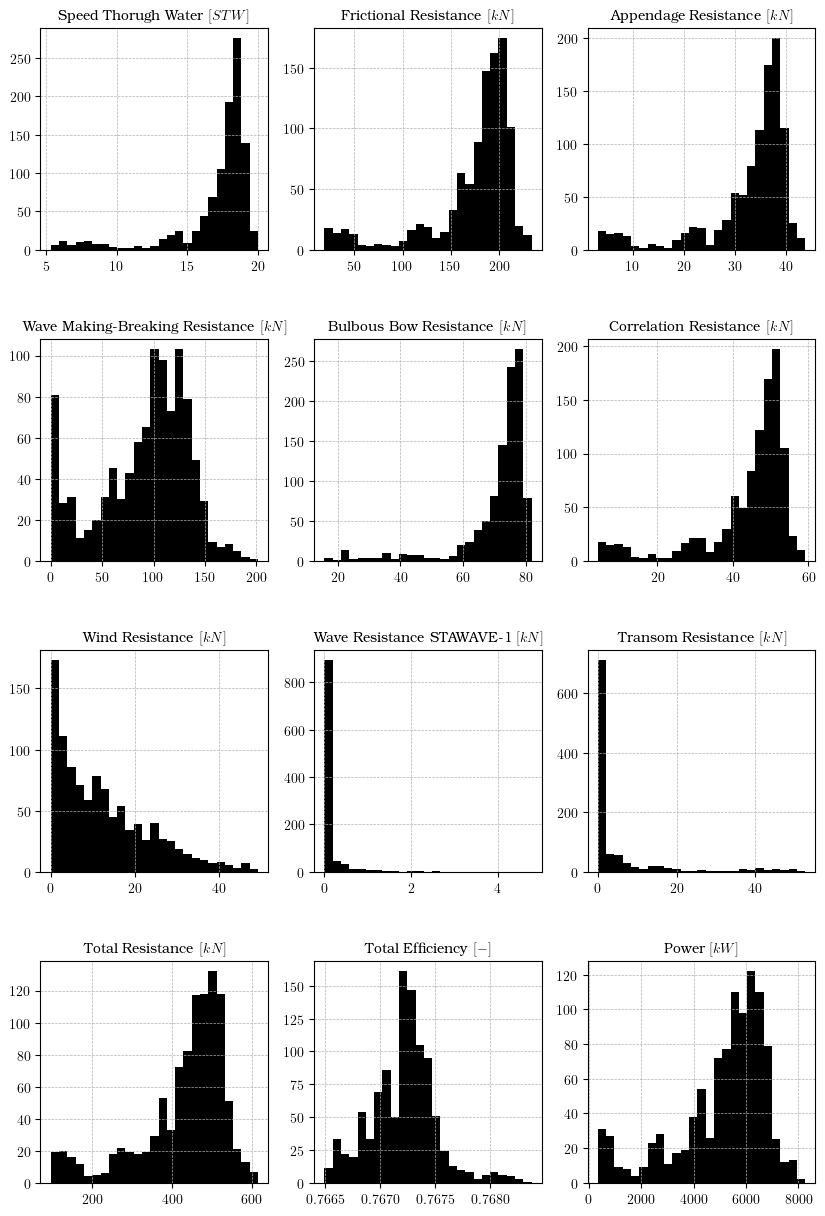

In [926]:
fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})


stw = stw_pred
R_f = Rf_pred/1e3
R_app = R_app_pred/1e3
R_w = R_w_pred/1e3
R_b = R_b_pred/1e3
R_tr = R_tr_pred/1e3
R_a = R_a_pred/1e3
R_aa = R_aa_pred/1e3
# R_aa_hm = dfprog_f['R_aa_hm']/1e3
R_awl = R_awl_pred/1e3
R_tot = R_tot_pred
# eff_h = dfprog_f['eff_h']
eff_tot = eff_tot_pred
P_b = P_b_pred
FOC = FOC_pred



fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(stw,bins=25,color='black')
axes[0, 0].set_title(r'Speed Thorugh Water $[STW]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(R_f,bins=25,color='black')
axes[0, 1].set_title(r'Frictional Resistance $[kN]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(R_app,bins=25,color='black')
axes[0, 2].set_title(r'Appendage Resistance $[kN]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(R_w,bins=25,color='black')
axes[1, 0].set_title(r'Wave Making-Breaking Resistance $[kN]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(R_b  ,bins=25,color='black')
axes[1, 1].set_title(r'Bulbous Bow Resistance $[kN]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(R_a,bins=25,color='black')
axes[1, 2].set_title(r'Correlation Resistance $[kN]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(R_aa,bins=25,color='black')
axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[2, 0].hist(R_aa_hm,bins=25,color='black')
# axes[2, 0].set_title(r'Wind Resistance $[kN]$', fontsize=fs)
# axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(R_awl,bins=25,color='black')
axes[2, 1].set_title(r'Wave Resistance STAWAVE-1 $[kN]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(R_tr,bins=25,color='black')
axes[2, 2].set_title(r'Transom Resistance $[kN]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(R_tot,bins=25,color='black')
axes[3, 0].set_title(r'Total Resistance $[kN]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

# axes[3, 0].hist(eff_h,bins=25,color='black')
# axes[3, 0].set_title(r'Hull Efficiency $[-]$', fontsize=fs)
# axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(eff_tot,bins=25,color='black')
axes[3, 1].set_title(r'Total Efficiency $[-]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(P_b,bins=25,color='black')
axes[3, 2].set_title(r'Power $[kW]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

# axes[4, 1].hist(FOC,bins=25,color='black')
# axes[4, 1].set_title(r'Fuel Consumption $[t/h]$', fontsize=fs)
# axes[4, 1].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()